In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
!pip3 install fastseg --user

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms

import boltseg.info as binfo
import boltseg.utils as butils
import boltseg.dataset as bdataset
import boltseg.models as bmodels
import boltseg.loggers as bloggers

In [11]:
assert torch.cuda.is_available()

In [12]:
!nvidia-smi

Tue Dec 19 20:44:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:04:00.0 Off |                  N/A |
| 21%   20C    P8     9W / 250W |      4MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:05:00.0 Off |                  N/A |
| 21%   

In [13]:
DEVICE_ID = 6
device = torch.device(f"cuda:{DEVICE_ID}")
device = "cpu"
print(f"Using device: {device}")

Using device: cuda:6


### Load dataset

In [14]:
test_size = 0.1
valid_size = 0.1

train_ds, valid_ds, test_ds = bdataset.split_dataset(validation_size=valid_size,
                                                     test_size=test_size)

train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=2, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=2, shuffle=False)

In [20]:
config["learning_rate"]

0.001

### Setup model

In [21]:
config = binfo.TRAINING_CONFIG
config["experiment_name"] = "mobilenet_pretrained_01_augmented"
config["device"] = str(device)
config["learning_rate"] = 5e-4
config["num_epochs"] = 40
butils.print_config(config)

model = bmodels.MobilenetSmallModel(num_classes=binfo.NUM_CLASSES).to(device)
optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])
loss_fn = nn.CrossEntropyLoss(weight=torch.tensor([2.0, 1.0, 2.0]).to(device))

logger = bloggers.WandbLogger(config)

{
  project_name  :  boltseg
  experiment_name  :  mobilenet_pretrained_01_augmented
  learning_rate  :  0.0005
  batch_size  :  8
  num_epochs  :  40
  device  :  cuda:6
}
Loading pretrained model mobilev3small-lraspp with F=128...


In [22]:
for epoch in range(config["num_epochs"]):
    # train
    info = model.train_step(train_dl, loss_fn, optimizer, device)
    logger.log(info, step=epoch+1)
    train_loss = info["train_loss"]
    
    # validate
    info = model.validation_step(valid_dl, loss_fn, device)
    logger.log(info, step=epoch+1)
    valid_loss = info["val_loss"]
    
    print(f"Epoch: {epoch+1} | Train loss: {train_loss:.5f} | Val loss: {valid_loss:.5f}")
    
logger.finish()

Epoch: 1 | Train loss: 0.60961 | Val loss: 0.29089
Epoch: 2 | Train loss: 0.13815 | Val loss: 0.09464
Epoch: 3 | Train loss: 0.07192 | Val loss: 0.05717
Epoch: 4 | Train loss: 0.04815 | Val loss: 0.03990
Epoch: 5 | Train loss: 0.03809 | Val loss: 0.03667
Epoch: 6 | Train loss: 0.03044 | Val loss: 0.02846
Epoch: 7 | Train loss: 0.02504 | Val loss: 0.02290
Epoch: 8 | Train loss: 0.02213 | Val loss: 0.02059
Epoch: 9 | Train loss: 0.02036 | Val loss: 0.01909
Epoch: 10 | Train loss: 0.01807 | Val loss: 0.01687
Epoch: 11 | Train loss: 0.01668 | Val loss: 0.01620
Epoch: 12 | Train loss: 0.01617 | Val loss: 0.01496
Epoch: 13 | Train loss: 0.01482 | Val loss: 0.01377
Epoch: 14 | Train loss: 0.01338 | Val loss: 0.01464
Epoch: 15 | Train loss: 0.01308 | Val loss: 0.01383
Epoch: 16 | Train loss: 0.01268 | Val loss: 0.01205
Epoch: 17 | Train loss: 0.01213 | Val loss: 0.01189
Epoch: 18 | Train loss: 0.01119 | Val loss: 0.01141
Epoch: 19 | Train loss: 0.01120 | Val loss: 0.01154
Epoch: 20 | Train los

### Segmentation for training data

torch.Size([512, 682])


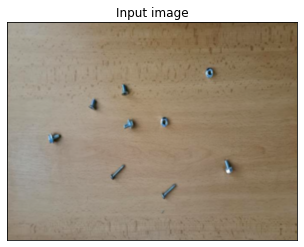

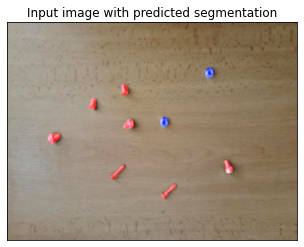

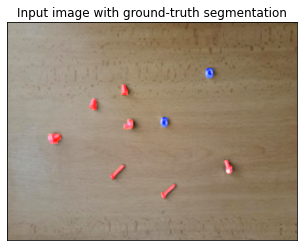

In [23]:
img, mask = train_ds[1]
predicted_mask = model(img.unsqueeze(0).to(device)).squeeze().argmax(dim=0)
print(predicted_mask.shape)

butils.show_img(img, title="Input image")
img_with_mask = butils.applymask(img.clone(), predicted_mask)
butils.show_img(img_with_mask, title="Input image with predicted segmentation")
img_with_mask2 = butils.applymask(img.clone(), mask)
butils.show_img(img_with_mask2, title="Input image with ground-truth segmentation")

### Segmentation for validation data

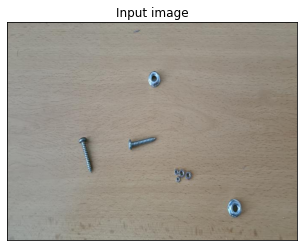

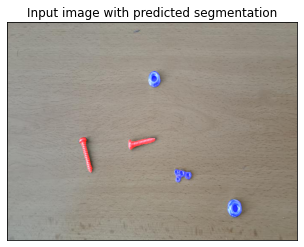

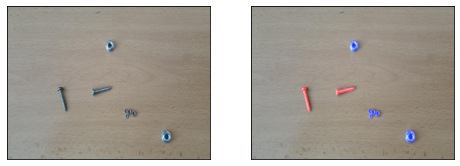

In [24]:
img = valid_ds[0][0]
predicted_mask = model(img.unsqueeze(0).to(device)).squeeze().argmax(dim=0).cpu()

butils.show_img(img, title="Input image")
img_with_mask = butils.applymask(img, predicted_mask)
butils.show_img(img_with_mask, title="Input image with predicted segmentation")

butils.compare_images(img, img_with_mask)

### Segmentation for testing data

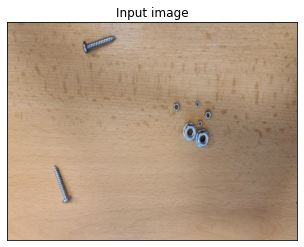

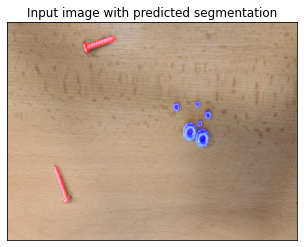

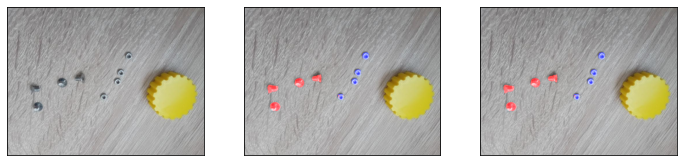

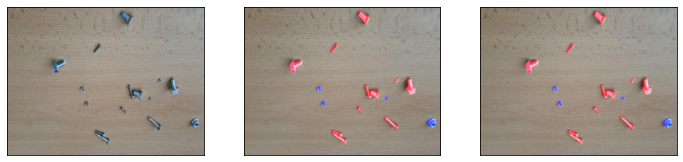

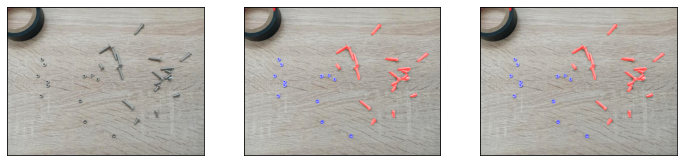

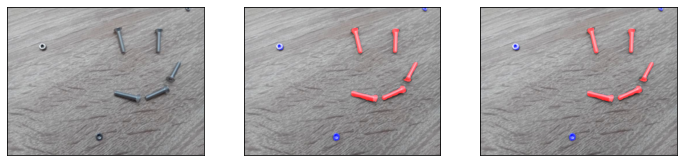

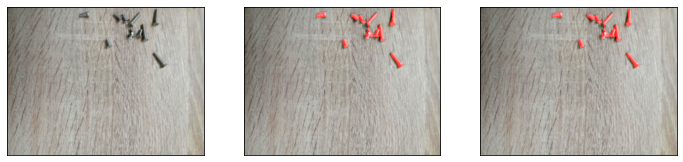

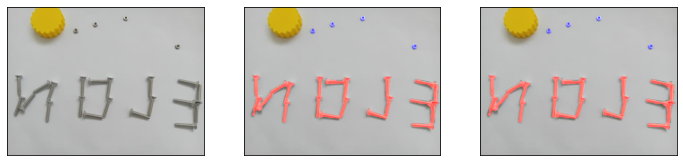

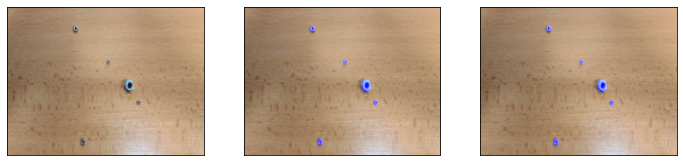

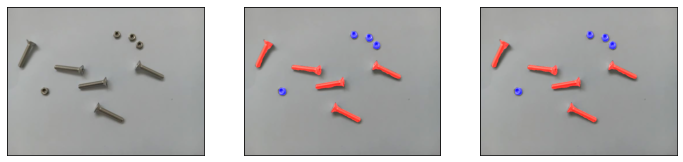

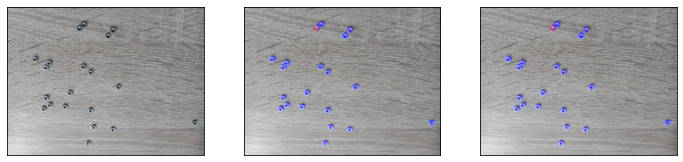

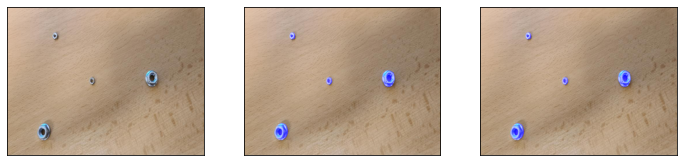

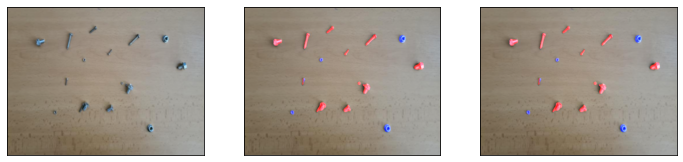

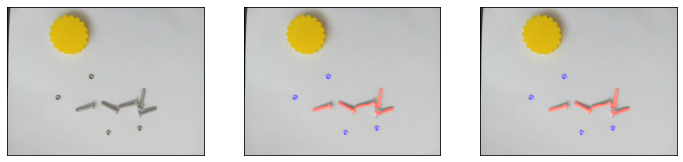

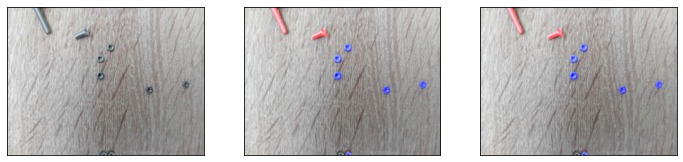

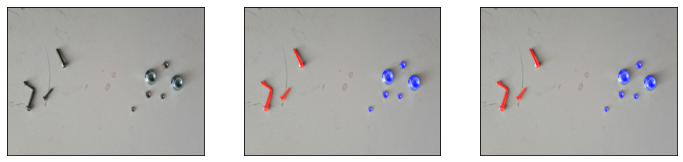

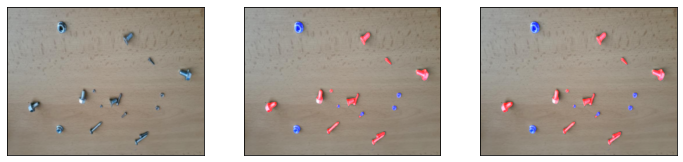

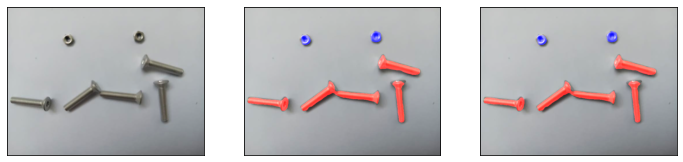

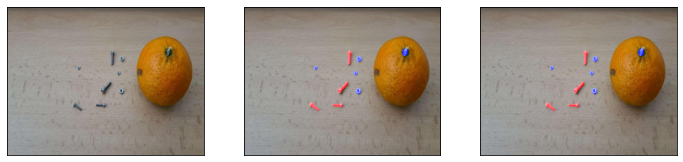

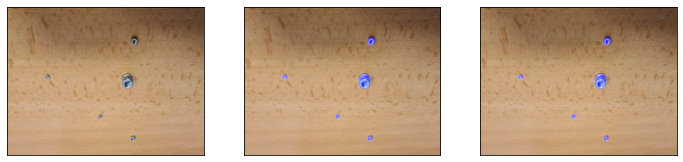

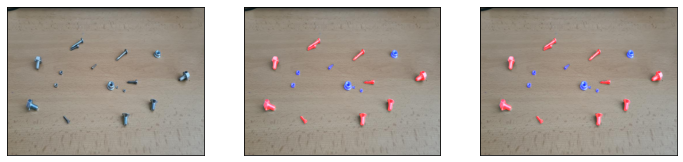

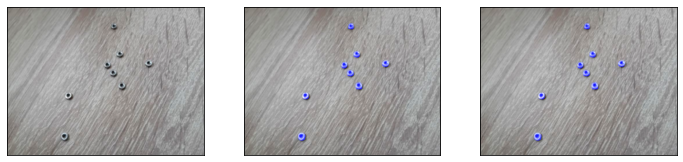

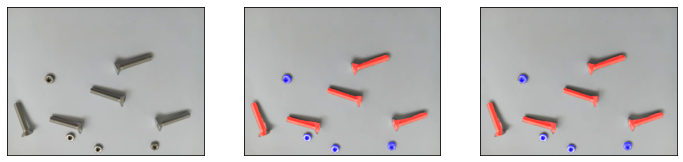

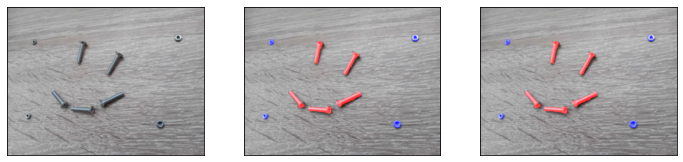

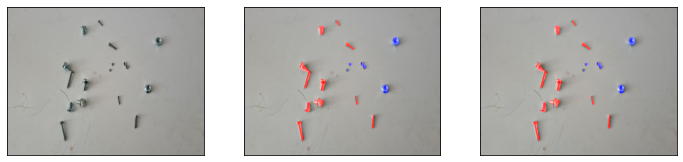

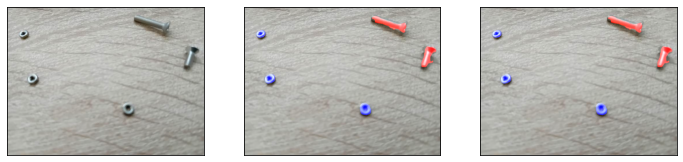

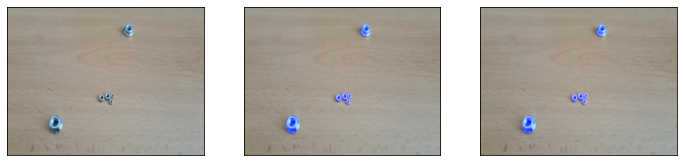

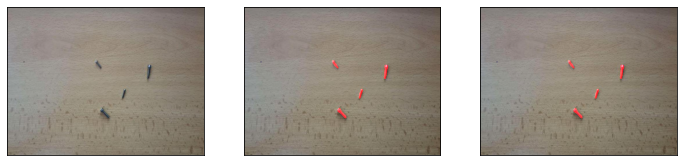

In [25]:
img = test_ds[0][0]
predicted_mask = model(img.unsqueeze(0).to(device)).squeeze().argmax(dim=0).cpu()

butils.show_img(img, title="Input image")
img_with_mask = butils.applymask(img, predicted_mask)
butils.show_img(img_with_mask, title="Input image with predicted segmentation")

for i in range(1, len(test_ds)):
    img = test_ds[i][0]
    predicted_mask = model(img.unsqueeze(0).to(device)).squeeze().argmax(dim=0).cpu()
    img_with_mask = butils.applymask(img, predicted_mask)
    butils.compare_images(img, img_with_mask, img_with_mask)

### Segment video

In [27]:
import os
input_video = os.path.join(binfo.DATASET_PATH, "testing_video.mp4")
output_video = "segmented_video.mp4"

butils.segment_video(input_video, output_video, model)